In [1]:
from keras.preprocessing.text import Tokenizer
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# We create a tokenizer, configured to only take
# into account the top-1000 most common words
tokenizer = Tokenizer(num_words=1000)

# This builds the word index
tokenizer.fit_on_texts(samples)

# This turns strings into lists of integer indices.
sequences = tokenizer.texts_to_sequences(samples)

# You could also directly get the one-hot binary representations.
# Note that other vectorization modes than one-hot encoding are supported!
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# This is how you can recover the word index that was computed
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 9 unique tokens.


In [3]:
# Hashing encoding example

import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
# We will store our words as vectors of size 1000.
# Note that if you have close to 1000 words (or more)
# you will start seeing many hash collisions, which
# will decrease the accuracy of this encoding method.
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # Hash the word into a "random" integer index
        # that is between 0 and 1000
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

In [7]:
# Word embeddings are dense, lower-dimensional, and learned from data as compared to one-hot word vectors

# Load IMDB data for use with Embedding layer
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [9]:
# Use embedding layer and classifier on IMDB data
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()

# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))

# After the Embedding layer,
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 169us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 2s 111us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 2s 111us/step - los

In [11]:
# Process labels of raw IMDB data

import os
imdb_dir = '/home/stephen/Downloads/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [12]:
# Tokenize the raw IMDB data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # We will cut reviews after 100 words
training_samples = 200 # We will be training on 200 samples
validation_samples = 10000 # We will be validating on 10000 samples

max_words = 10000 # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [17]:
# Parse the GloVe word embeddings file
glove_dir = '/home/stephen/Downloads/glove.6B'

embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [18]:
# Prepare GloVe word embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [19]:
# Define model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Load matrix of pre-trained word embeddings into Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [21]:
# Train and evaluate
model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 1.9663 - acc: 0.5050 - val_loss: 0.7520 - val_acc: 0.5217
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5116 - acc: 0.7300 - val_loss: 0.6836 - val_acc: 0.5625
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4144 - acc: 0.8050 - val_loss: 0.7854 - val_acc: 0.5167
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2911 - acc: 0.9050 - val_loss: 0.6985 - val_acc: 0.5688
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3274 - acc: 0.8400 - val_loss: 0.6882 - val_acc: 0.5737
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1308 - acc: 1.0000 - val_loss: 0.7309 - val_acc: 0.5592
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1393 - acc: 0.9700 - val_loss: 1.5227 - val_acc: 0.4939
Epoch 8/10
200/200 [========

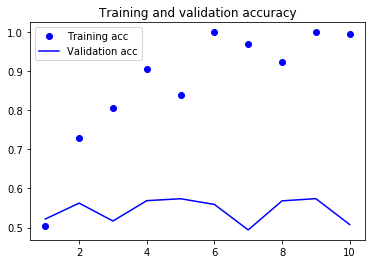

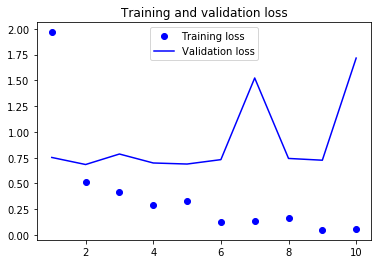

In [23]:
# Plot results

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()